In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

import random, math
from nsga2 import Solution
from nsga2 import NSGAII

% matplotlib inline

Define test function

In [3]:
class ZDT1Solution(Solution):
    '''
    Solution for the ZDT1 function.
    '''
    def __init__(self):
        '''
        Constructor.
        '''
        Solution.__init__(self, 2)
        
        self.xmin = 0.0
        self.xmax = 1.0
        
        for _ in range(30):
            self.attributes.append(random.random())
        
        self.evaluate_solution()
        
    def evaluate_solution(self):
        '''
        Implementation of method evaluate_solution() for ZDT1 function.
        '''
        self.objectives[0] = self.attributes[0]
        
        sum = 0.0
        for i in range(1, 30):
            sum += self.attributes[i]
            
        g = 1.0 + (9.0 * (sum / 29))
        
        self.objectives[1] = g * (1.0 - math.sqrt(self.attributes[0] / g))
        
    def crossover(self, other):
        '''
        Crossover of ZDT1 solutions.
        '''
        child_solution = ZDT1Solution()
        
        for i in range(30):
            child_solution.attributes[i] = math.sqrt(self.attributes[i] * other.attributes[i])
        
        return child_solution
    
    def mutate(self):
        '''
        Mutation of ZDT1 solution.
        '''
        self.attributes[random.randint(0, 29)] = random.random()

In [16]:
nsga2 = NSGAII(2, 0.9, 0.03)

P = []

n_population = 50
n_iterations = 200

for i in range(n_population):
    P.append(ZDT1Solution())
    
Q = nsga2.initialise(P)

Ps = []
t0 = time.time()
for ii in range(n_iterations):
    if ii % 10 == 0:
        print('Iteration', ii, '- Elapsed time:', time.time() - t0)
    P, Q = nsga2.generate(P, Q, n_population, n_iterations)
    Ps.append(copy.deepcopy(P))

Iteration 0 - Elapsed time: 0.0
Iteration 10 - Elapsed time: 0.19251227378845215
Iteration 20 - Elapsed time: 0.3995625972747803
Iteration 30 - Elapsed time: 0.6031041145324707
Iteration 40 - Elapsed time: 0.807647705078125
Iteration 50 - Elapsed time: 1.0061757564544678
Iteration 60 - Elapsed time: 1.2097172737121582
Iteration 70 - Elapsed time: 1.426293134689331
Iteration 80 - Elapsed time: 1.6318397521972656
Iteration 90 - Elapsed time: 1.8559355735778809
Iteration 100 - Elapsed time: 2.064491033554077
Iteration 110 - Elapsed time: 2.264522075653076
Iteration 120 - Elapsed time: 2.470069169998169
Iteration 130 - Elapsed time: 2.6756157875061035
Iteration 140 - Elapsed time: 2.881162166595459
Iteration 150 - Elapsed time: 3.0982396602630615
Iteration 160 - Elapsed time: 3.309802293777466
Iteration 170 - Elapsed time: 3.517855405807495
Iteration 180 - Elapsed time: 3.716383457183838
Iteration 190 - Elapsed time: 3.9244368076324463


Visualise final generation 

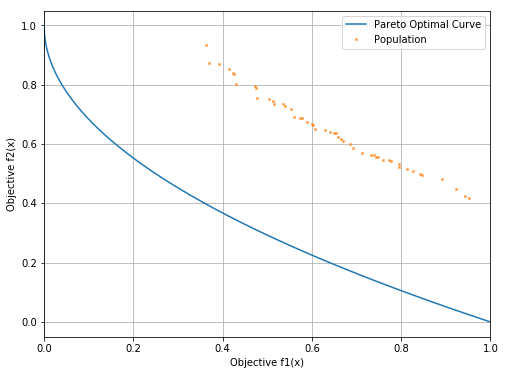

In [17]:
plt.figure(figsize = (8, 6))

f1 = np.linspace(0, 1, 1000)
f2 = 1.0 - np.sqrt(f1)
plt.plot(f1, f2, label = 'Pareto Optimal Curve')

plt.plot([p.objectives[0] for p in Ps[-1]], 
         [p.objectives[1] for p in Ps[-1]],
         'x', 
         markersize = 2,
         label = 'Population')

plt.ylabel('Objective f2(x)')
plt.xlabel('Objective f1(x)')
plt.grid(which = 'both')
plt.legend()
plt.xlim([0, 1])
plt.show()